# Prompt Engineering Basic Techniques

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio on ml.t3.medium instance*

---

In this demo notebook, we demonstrate how to use the boto3 Python SDK to work with Amazon Bedrock Foundation Models. If you are running this in AWS provided accounts, excessive API calls to Bedrock APIs may results in throttling and your account may get blocked

In this demo notebook, we are going to explore some of the PROMPT Engineering Techniques for better model output generation.


---

In [1]:
import sys
import os
module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils.environment_validation import validate_environment, validate_model_access
validate_environment()

Validating base environment
awscli>=1.29.57 has been installed successfully.
Base environment validated successfully


Validating lab environment from requirements.txt ✨

ENVIRONMENT STATUS
✅  matplotlib is installed
❌ langchain==0.3.7 is not installed
❌ langchain-aws==0.2.6 is not installed
❌ langchain-community==0.3.5 is not installed
❌ langchain-core==0.3.15 is not installed
❌ langchain-text-splitters==0.3.2 is not installed
❌ sqlalchemy is not installed
❌ pypdf>=3.8,<4 is not installed
❌ datasets is not installed
❌ pymupdf  is not installed
❌ xmltodict==0.13.0 is not installed
❌ duckduckgo-search is not installed
❌ yfinance==0.2.40 is not installed
❌ pandas-datareader is not installed
❌ pysqlite3 is not installed

Installing missing libraries

langchain==0.3.7 has been installed successfully.
langchain-aws==0.2.6 has been installed successfully.
langchain-community==0.3.5 has been installed successfully.
langchain-core==0.3.15 has been installed successfully.
langchain-text-splitters==0.3.2 has been installed successfully.
sqlalchemy has been installed successfully.
pypdf>=3.8,<4 has been installed successfully.
datasets has been installed successfully.
pymupdf  has been installed successfully.
xmltodict==0.13.0 has been installed successfully.
duckduckgo-search has been installed successfully.
yfinance==0.2.40 has been installed successfully.
pandas-datareader has been installed successfully.
pysqlite3 has been installed successfully.


All required libraries are installed.🎉
You may proceed with the lab! 🚀

In [3]:
required_models = [
    "amazon.titan-embed-text-v1",
    "anthropic.claude-3-sonnet-20240229-v1:0",
    "anthropic.claude-3-haiku-20240307-v1:0",
]
validate_model_access(required_models)

MODEL ACCESS STATUS
✅  amazon.titan-embed-text-v1 is accessible
✅  anthropic.claude-3-sonnet-20240229-v1:0 is accessible
✅  anthropic.claude-3-haiku-20240307-v1:0 is accessible

All required models are accessible.🎉
You may proceed with the lab! 🚀

In [4]:

#Create the bedrock client for model access
import json

from rich import print as rprint
from rich.markdown import Markdown

import boto3
import botocore

from utils.prompt_utils import prompts_to_messages, convert_pdf_to_image, convert_pil_image_to_b64

boto3_bedrock = boto3.client("bedrock")

#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [5]:

boto3_bedrock.list_foundation_models()


{'ResponseMetadata': {'RequestId': 'c80fc32c-126d-4c7f-bcef-187cf23a297c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 08 Jan 2025 16:28:20 GMT',
   'content-type': 'application/json',
   'content-length': '33918',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c80fc32c-126d-4c7f-bcef-187cf23a297c'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': [],
   'inferenceTypesSupported': ['ON_DEMAND'],
   'modelLifecycle': {'status': 'ACTIVE'}},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1:0',
   'modelId': 'amazon.titan-image-generator-v1:0',
   'modelName': 'Titan Image Generator G1',
   'providerName': 'Amazon',

---

## `InvokeModel` body and output

The `invoke_model()` method of the Amazon Bedrock runtime client (`InvokeModel` API) will be the primary method we use for most of our Text Generation and Processing tasks - whichever model we're using.

Although the method is shared, the format of input and output varies depending on the foundation model used - as described below:

### Anthropic Claude Completion API format

#### Input

```json
{
    "prompt": "\n\nHuman:<prompt>\n\nAnswer:",
    "max_tokens_to_sample": 300,
    "temperature": 0.5,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman:"]
}
```

#### Output

```json
{
    "completion": "<output>",
    "stop_reason": "stop_sequence"
}
```

### Anthropic Claude Messages API format

#### Example with a single user message: 

```json
[{"role": "user", "content": "Hello, Claude"}]
```

#### Example with multiple conversational turns:

```json
[
  {"role": "user", "content": "Hello there."},
  {"role": "assistant", "content": "Hi, I'm Claude. How can I help you?"},
  {"role": "user", "content": "Can you explain LLMs in plain English?"},
]
```

#### Example with a partially-filled response from Claude:

```json
[
  {"role": "user", "content": "Please describe yourself using only JSON"},
  {"role": "assistant", "content": "Here is my JSON description:\n{"},
]
```

Each input message content may be either a single string or an array of content blocks, where each block has a specific type. Using a string is shorthand for an array of one content block of type "text". The following input messages are equivalent:

```json
{"role": "user", "content": "Hello, Claude"}
```

```json
{"role": "user", "content": [{"type": "text", "text": "Hello, Claude"}]}
```


---

## Try out the Claude Model

With some theory out of the way, let's see the models in action! Run the cells below to see basic, synchronous example invocations for each model:


In [6]:

bedrock_runtime = boto3.client("bedrock-runtime")


#### Claude Prompts
As the message based API has become the standard way to prompt Claude models, we will utilize a small helper function `prompts_to_messages` that will convert our prompt into the message format expected by the API.

In [7]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Write me a blog about making strong business decisions as a leader"""


In [8]:

body = json.dumps({
    "max_tokens": 256,
    "messages": prompts_to_messages(prompt_data),
    "anthropic_version": "bedrock-2023-05-31"
})


modelId = "anthropic.claude-3-sonnet-20240229-v1:0"  
# you can change the model_id to use a different version from the model provider
# Examples 
# modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
# modelId = "anthropic.claude-3-haiku-20240307-v1:0" 
# modelId = "anthropic.claude-v2:1" 

accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    rprint(response_body.get("content")[0]["text"])

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error
    

Here is a draft blog post on making strong business decisions as a leader:

Title: The Key to Strong Leadership: Making Tough Business Decisions with Confidence

As a leader, one of the most important responsibilities you have is making critical business decisions. The choices
you make can determine the success or failure of your company and impact the livelihoods of your employees. With so
much at stake, it's vital to approach decision-making with clarity, wisdom and an unwavering commitment to doing 
what's best for the organization.

Strong leaders don't shy away from tough decisions – in fact, they lean into them. While it's never easy to make 
difficult choices, truly effective leaders develop a decision-making process that allows them to act swiftly and 
confidently when faced with complicated challenges. Here are some strategies for mastering this essential 
leadership skill:

Gather all relevant data. Don't attempt to make a major decision based on incomplete information or assumptions. 
Take the time to collect accurate data and input from relevant experts, stakeholders and trusted advisors. Leave no
stone unturned when it comes to understanding the factors at play.

Consider multiple scenarios. Once you've done your research, lay out all the potential options and outcomes. What

## Prompt Engineering - Basic Techiques

In this section, we are going to explore some basic prompting engineering techniques.

---

### Zero-shot prompting
Zero Shot prompting describes the technique where we present a task to an LLM without giving it further examples. We therefore, expect it to perform the task without getting a prior “shot” at the task. Hence, “zero-shot” prompting. Modern LLMs demonstrate remarkable zero-shot performance and a positive correlation can be drawn between model size and zero-shot performance.

In [9]:

# If you'd like to try your own prompt, edit this parameter!
system_prompt = """You are a customer service agent tasked with classifying emails by type. Please output your answer and then justify your classification. How would you categorize this email? """

prompt_data = """
<email>
I would like to know how I can contribute to my retirement account? Any additional resources to read about IRA would be helpful
</email> 
Provide and explanation for your choice of answer

The categories are: 
(A) IRA 
(B) 529 Plan
(C) Cash Management
(D) Youth Account
"""



In [10]:
body = json.dumps({
    "max_tokens": 1024,
    "system": system_prompt,
    "messages": prompts_to_messages(prompt_data),
    "anthropic_version": "bedrock-2023-05-31"
})


modelId = "anthropic.claude-3-sonnet-20240229-v1:0"  
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

rprint(response_body.get("content")[0]["text"])




Based on the content of the email, the appropriate category would be:

(A) IRA

Justification:
The email explicitly mentions the desire to contribute to a retirement account and requests additional resources 
about IRAs (Individual Retirement Accounts). IRAs are tax-advantaged accounts designed for individuals to save and 
invest for their retirement. Since the email is specifically inquiring about IRAs and contributing to a retirement 
account, the most relevant category is IRA.

---

### Few-shot prompting
Giving the model more information about the tasks at hand via examples is called Few-Shot Prompting. It can be used for in-context learning by providing examples of the task and the desired output. We can therefore condition the model on the examples to follow the task guidance more closely.

In [11]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Your job is to generate financial summaries similar to the examples below: 

Microsoft: Microsoft reported record revenue of $51.9 billion in its latest quarterly earnings report, a 20% increase year-over-year. Its net income rose to $16.7 billion, up 21% compared to the previous year. Microsoft's revenue growth was driven by its cloud computing business Azure and Office 365 productivity tools.

Amazon: In its most recent quarterly results, Amazon reported net sales of $96.1 billion, an increase of 15% compared to the same period last year. Amazon's net income decreased to $2.9 billion, down 58% year-over-year, as the company faced rising costs due to inflation and supply chain issues. Amazon Web Services, its cloud computing segment, continued to see strong growth with sales up 33%.

Now provide a brief financial summary for Apple Inc. based on the following key facts:
- Revenue for the last 12 months: $260 billion 
- Net income: $55 billion
- Total assets: $321 billion
- Market capitalization: $2.2 trillion

"""

In [12]:


body = json.dumps(
    {
        "max_tokens": 1024,
        "messages": prompts_to_messages(prompt_data),
        "anthropic_version": "bedrock-2023-05-31",
    }
)

modelId = "anthropic.claude-3-sonnet-20240229-v1:0"  
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

rprint(response_body.get("content")[0]["text"])

Apple Inc. Financial Summary:

Apple reported impressive financial results over the last 12 months, with record revenue of $260 billion. The tech 
giant's net income stood at a staggering $55 billion, reflecting its strong profitability. Apple's total assets 
amounted to $321 billion, indicating a robust financial position.

Perhaps the most remarkable figure is Apple's market capitalization, which soared to an astounding $2.2 trillion, 
making it one of the most valuable companies in the world. This mammoth valuation underscores the market's 
confidence in Apple's ability to maintain its dominance in the technology sector and sustain its remarkable growth 
trajectory.

With its strong financial performance, substantial assets, and unparalleled market capitalization, Apple continues 
to solidify its position as a tech industry leader and a powerhouse in the global economy.

---

### Chain of Thought prompting
Chain-of-thought (CoT) prompting enables complex reasoning capabilities through intermediate reasoning steps. You can combine it with few-shot prompting to get better results on more complex tasks that require reasoning before responding. The main idea of CoT is that by showing the LLM some few shot exemplars where the reasoning process is explained in the exemplars, the LLM will also show the reasoning process when answering the prompt. This explanation of reasoning often leads to more accurate results.


In [13]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """
Apple Inc. key facts:
- Revenue for the last 12 months: $260 billion 
- Operating Expenses: $205 billion
- Total assets: $321 billion
- Market capitalization: $2.2 trillion

If Apple's revenue is expected to grow by 10% in the next year, however it's expenses are expected to increase by 15%, what would be the expected net income for Apple in the next year?

Think step-by-step and provide your thought process in the <thinking></thinking> XML tags and the final answer in the <answer></answer> XML tags.

"""

In [14]:
body = json.dumps(
    {
        "max_tokens": 1024,
        "messages": prompts_to_messages(prompt_data),
        "anthropic_version": "bedrock-2023-05-31",
    }
)

modelId = "anthropic.claude-3-sonnet-20240229-v1:0" 
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("content")[0]["text"])

<thinking>
To calculate the expected net income for Apple in the next year, we need to:
1. Calculate the expected revenue for the next year based on the 10% growth rate
2. Calculate the expected expenses for the next year based on the 15% increase
3. Subtract the expected expenses from the expected revenue to get the expected net income

Given:
- Current revenue (last 12 months): $260 billion
- Current expenses: $205 billion
- Expected revenue growth rate: 10%
- Expected expense increase rate: 15%

Step 1: Calculate the expected revenue for the next year
Expected revenue = Current revenue + (Current revenue × Expected growth rate)
Expected revenue = $260 billion + ($260 billion × 0.1)
Expected revenue = $260 billion + $26 billion
Expected revenue = $286 billion

Step 2: Calculate the expected expenses for the next year
Expected expenses = Current expenses + (Current expenses × Expected expense increase rate)
Expected expenses = $205 billion + ($205 billion × 0.15)
Expected expenses = $

## Prompt Engineering - Different task examples

---

### Conversation Summarization
Prompt engineering for conversation summarization is a process of crafting prompts that guide a language model like Claude in summarizing dialogues or conversations effectively.

In [15]:
conversation_summary_prompt = """
Provide a concise bullet-point summary of the following conversation
<conversation>
Susan: Welcome back, Chuck. This is the second part of our interview, and I want to ask you these questions as quickly as possible because I know you have a flight to catch, so. . . .

Chuck: No problem. I’m happy to chat with you.

Susan: It says on your website that you never studied business before accepting a marketing role at a Spanish-speaking multimedia publisher. Was … was that—

Chuck: Yeah.

Susan: So was that more of a stretch, or … ?

Chuck: Yeah, well, actua—

Susan: Oh, I’m sorry, just a minute. Can everyone else just put themselves on mute, please?

Akim: [inaudible 00:37]

Susan: Great, thanks. OK, so where were we? So, I was asking you if, when you took the new role as Director, it felt like a stretch?

Chuck: Right, yeah. . . . I knew there would be a period of adjustment that I just would have to push through, you know?

Susan: Absolutely. Were there any other challenges or roadblocks that you weren’t expecting though?

Chuck: Hm, roadblocks I wasn’t expecting. Um…

Susan: [laughs] I keep throwing you curveballs.

Chuck: No, it’s OK. So, I actually didn’t anticipate the workload involved in learning a foreign language on the job. It’s like, you know, sometimes. . . . I mean, you need to be really flexible and ready to change it up if your strategy isn’t actually working. Know what I mean?

Susan: [laughs] Definitely. So what was your budget like, I mean, was that, like, a challenge, too?

Chuck: Hoo boy. [laughs] Yeah it definitely was. We had funding available, but we just, um, needed so many hands on deck. It was hard to, you know, actually manage so many people with our existing resources. [coughs]

Susan: I totally understand. So what was your next move? I mean, did you—

Chuck: Yeah, yeah. . . . So next, I kind of wanted to see where I do a gap analysis and throw resources at new initiatives where we weren’t, uh, I mean, I wanted to actually close the loop in those places where we didn’t quite have a foothold.

Susan: Nice, nice.

Chuck: Yeah, we really just needed to keep what was working and then lay out a new plan for [clears throat] future growth.

Susan: So, it looks like we have time for maybe, um, let’s see— maybe one more question.

Chuck: Sounds good. Shoot.

Susan: How did this experience change the way you approached new challenges going forward?

Chuck: Hm, good one. [laughs] I think that I was less, uh, likely to question my own judgement when it came to adaptability. Now I know that I really have it in me, you know?

Really all it takes is a great marketing team underneath you and the freelance resources to put together the best marketing initiative you can afford, you know, with, um, the standard tools high-quality content, good ad placement, good SEO, a strong social presence and then maybe debut a new idea every six months. Um, like, you could come up with a certain theme or catch phrase and actually weave it through all your branding and regular initiatives.

Susan: OK, well thanks, Chuck. This is really good stuff. I know you have to run, um, but I’d just like to thank you for, you know, taking this time with me today.

Chuck: Sure, sure. Of course
</conversation>

"""

In [16]:
body = json.dumps({
    "max_tokens": 1024,
    "messages": prompts_to_messages(conversation_summary_prompt),
    "anthropic_version": "bedrock-2023-05-31"
})


modelId = "anthropic.claude-3-sonnet-20240229-v1:0"  
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

rprint(response_body.get("content")[0]["text"])

    

Here is a concise bullet point summary of the conversation:

• Chuck took on a marketing director role at a Spanish multimedia publisher despite having no prior business 
education

• Learning a new language on the job was an unexpected challenge 

• Flexibility and willingness to change strategy were important 

• Limited budget and resources made managing a large team difficult

• He did a gap analysis to identify areas needing more resources/initiatives 

• The experience made him more confident in his ability to adapt 

• For future challenges, he recommends having a strong marketing team, using standard tools like content/ads/SEO, 
maintaining an active social presence, and regularly launching new branded initiatives

### Question & Answering
Prompt engineering for question answering is a process of crafting prompts that guide a language model like Claude in answering questions on provided context effectively. This is used as a basis for more advanced techniques such as Retrieval-Augmented Generation (RAG).

In [17]:
system_prompt = """You are a customer service agent tasked with answering questions about various financial products and services. Please output your answer and then justify your classification. """

qna_prompt = """
<context>
When the teen turns 18, their account is eligible to transition to the regular Fidelity brokerage account with expanded features like option and margin trading.
The teen will be prompted to transition their account starting on their 18th birthday. They will have 60 days to do so before their debit card and ability to trade will be restricted. Once the account is transitioned, the debit card that the teen was issued for their Fidelity Youth™ Account will continue to be valid until it expires; at that point, a new debit card will be issued.
Once a teen turns 18, the teen may choose whether or not the parent/guardian will continue to have access to that teen’s Fidelity Youth Account information. Teens can still use the Fidelity Youth™ app when they turn 18, however additional capabilities are available to them in the Fidelity mobile app.
</context> 

<question> What is the role of a parent/ guardian according to Fidelity youth accounts? </question>

"""


In [18]:
body = json.dumps(
    {
        "max_tokens": 1024,
        "system": system_prompt,
        "messages": prompts_to_messages(qna_prompt),
        "anthropic_version": "bedrock-2023-05-31",
    }
)

modelId = "anthropic.claude-3-sonnet-20240229-v1:0"  
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

rprint(response_body.get("content")[0]["text"])

According to the context provided, the role of a parent/guardian in Fidelity Youth Accounts is as follows:

1. The parent/guardian has access to the teen's Fidelity Youth Account information until the teen turns 18.

2. Once the teen turns 18, they have the choice to either allow or revoke the parent/guardian's access to their 
account information.

This shows that the parent/guardian plays an oversight and monitoring role for the teen's account until the teen 
becomes a legal adult at 18 years old. At that point, the decision to continue sharing account information with the
parent/guardian lies with the teen.

Classification: This describes the roles and permissions related to parental access and oversight of Fidelity Youth
Accounts, which are financial accounts aimed at teenagers.

### Content Generation
We can use prompt engineering to guide the model in generating content that is relevant to the task at hand. This can be used for generating content for a variety of tasks such as content creation, content summarization, and more.
In this example, the model will generate a table using provided data and as well as some questions that it can answer based on this data. This approach is common for getting the model to address more complex research type tasks where multiple steps are involved in generating the final output.

In [19]:
content_prompt = """Below is research that you performed previously. On basis of this research please answer the question below. 
If it does not include the exact answer, please respond with relevant information from the research in the response. Prefer more recent sources when possible.
If the context contains publication ids, please include citations in the response. Citations should be formatted as [publication_id] or [org_id]
If the user asks for a chart, return only machine readable json structure for the chart in HighCharts format without any formatting. 
Prefer answering in First Person (I, me, my) style.
In your response, after you answer draw a line, and include 3 additional questions you can answer with the research, one question per line.
Example:
{Your Answer}

Additional questions I can answer::
Question 1
Question 2
Question 3

<research>
JPMorgan Chase Bank, N.A. (164500) Financials: 
 
|Indicator|2020(annual)|2021(annual)|2022(annual)|
|---|---|---|---|
|Total assets (USD Billion)|3025.28|3306.98|3201.94|
|Tangible Common Equity (USD Billion)|221.41|262.33|280.96|
|Problem Loans / Gross Loans|1.64|1.14|1.00|
|Tangible Common Equity / Risk Weighted Assets|16.48|18.83|19.04|
|Problem Loans / (Tangible Common Equity + Loan Loss Reserve)|6.71|4.44|3.80|
|Net Interest Margin|2.13|1.74|2.22|
|PPI / Average RWA|3.30|2.90|3.45|
|Net Income / Tangible Assets|0.70|1.16|1.09|
|Cost / Income Ratio|58.76|61.90|57.71|
|Market Funds / Tangible Banking Assets|15.38|12.38|12.43|
|Liquid Banking Assets / Tangible Banking Assets|55.38|55.31|49.91|
|Gross Loans / Due to Customers|47.24|44.01|48.72|
 
Bank of America Corporation (541000) Financials: 
 
|Indicator|2020(annual)|2021(annual)|2022(annual)|
|---|---|---|---|
|Total assets (USD Billion)|2786.01|3146.17|3024.42|
|Tangible Common Equity (USD Billion)|174.68|175.58|190.40|
|Problem Loans / Gross Loans|1.18|0.95|0.91|
|Tangible Common Equity / Risk Weighted Assets|12.74|12.55|13.49|
|Problem Loans / (Tangible Common Equity + Loan Loss Reserve)|5.92|5.26|4.87|
|Net Interest Margin|1.75|1.52|1.82|
|PPI / Average RWA|1.94|1.96|2.23|
|Net Income / Tangible Assets|0.67|0.92|0.71|
|Cost / Income Ratio|67.23|69.57|66.12|
|Market Funds / Tangible Banking Assets|21.09|21.26|22.71|
|Liquid Banking Assets / Tangible Banking Assets|57.50|58.98|55.10|
|Gross Loans / Due to Customers|54.20|50.35|56.05|
 
Wells Fargo Bank, N.A. (811500) Financials: 
 
|Indicator|2020(annual)|2021(annual)|2022(annual)|
|---|---|---|---|
|Total assets (USD Billion)|1767.81|1779.50|1717.53|
|Tangible Common Equity (USD Billion)|145.47|148.21|149.95|
|Problem Loans / Gross Loans|1.69|1.36|1.14|
|Tangible Common Equity / Risk Weighted Assets|14.36|15.35|15.34|
|Problem Loans / (Tangible Common Equity + Loan Loss Reserve)|9.18|7.37|6.45|
|Net Interest Margin|2.41|2.13|2.77|
|PPI / Average RWA|1.46|1.91|2.22|
|Net Income / Tangible Assets|0.20|1.00|0.95|
|Cost / Income Ratio|75.75|69.83|67.73|
|Market Funds / Tangible Banking Assets|5.58|3.44|6.68|
|Liquid Banking Assets / Tangible Banking Assets|41.44|41.29|35.80|
|Gross Loans / Due to Customers|61.22|57.78|65.53|
 
</research>
 
<analysis>
 
(Doc Id: PBC_1362054, Publish Date: 2023-05-11, Title:Bank of America Corporation: Update to credit analysis following ratings upgrade)
 
1. Support and Structural Considerations:
About Moody's Bank ScorecardOur Bank Scorecard is designed to capture, express and explain in summary form our Rating Committee's judgment. When read in conjunction with our research, a fulsome presentation of our judgment is expressed. As a result, the output of our Scorecard may materially differ from that suggested by raw data alone (though it has been calibrated to avoid the frequent need for strong divergence). The Scorecard output and the individual scores are discussed in rating committees and may be adjusted up or down to reflect conditions specific to each rated entity. As per Moody's Banks rating methodology, the historic ratios in the scorecard for Capital are as of most recent period, for Asset Risk and Profitability they are the worse of the most recent year-to-date period or the average of the last three years and the most recent year-to-date, and for Funding Structure and Liquid Resources they are as of the most recent year-end.
2. RATINGS:
Please see the ratings section at the end of this report for more information. The ratings and outlook shown reflect information as of the publication date. 
Summary:
Bank of America Corporation (BAC, A1 stable) is the parent holding company for the second largest banking group in the US. The group is a global systemically important bank operating primarily through its principal bank subsidiary, Bank of America N.A. (BANA, Aa1 stable, a2 baseline credit assessment). BAC's credit profile is supported by its conservative risk appetite, a balanced and diversified business mix, strong funding and liquidity, robust cost discipline, strengthened capital and resilient profitability. During 2022, in response to increases in its regulatory capital requirements, BAC boosted its capital ratios significantly.
 
</analysis>
 
<questions>
1. Can you compare the financials for JPM, Bank of America and Wells fargo in a table format?
2. For statements referenced from documents include a reference in the format [docId].
DO NOT UNDER ANY CIRCUMSTANCES USE ANY DATA OTHER THAN MENTIONED IN THE RESEARCH SECTION.
</questions>

"""

In [20]:

body = json.dumps({
    "max_tokens": 1024,
    "messages": prompts_to_messages(content_prompt),
    "anthropic_version": "bedrock-2023-05-31"
})

modelId = "anthropic.claude-3-sonnet-20240229-v1:0" 
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

rprint(Markdown(response_body.get("content")[0]["text"]))

    

Based on the provided financial data for JPMorgan Chase Bank, N.A., Bank of America Corporation, and Wells Fargo   
Bank, N.A., here's a comparison of their key financial metrics in a table format:                                  

                                                                                                                   
  Indicator                      JPMorgan Chase Bank, N.A.   Bank of America Corporation   Wells Fargo Bank, N.A.  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Total assets (USD Billion)     3201.94                     3024.42                       1717.53                 
  (2022)                                                                                                           
  Tangible Common Equity (USD    280.96                      190.40                        149.95                  
  Billion) (2022)                                                                                                  
  Problem Loans / Gross Loans    1.00%                       0.91%                         1.14%                   
  (2022)                                                                                                           
  Tangible Common Equity /       19.04%                      13.49%                        15.34%                  
  Risk Weighted Assets (2022)                                                                                      
  Problem Loans / (Tangible      3.80%                       4.87%                         6.45%                   
  Common Equity + Loan Loss                                                                                        
  Reserve) (2022)                                                                                                  
  Net Interest Margin (2022)     2.22%                       1.82%                         2.77%                   
  PPI / Average RWA (2022)       3.45%                       2.23%                         2.22%                   
  Net Income / Tangible Assets   1.09%                       0.71%                         0.95%                   
  (2022)                                                                                                           
  Cost / Income Ratio (2022)     57.71%                      66.12%                        67.73%                  
  Market Funds / Tangible        12.43%                      22.71%                        6.68%                   
  Banking Assets (2022)                                                                                            
  Liquid Banking Assets /        49.91%                      55.10%                        35.80%                  
  Tangible Banking Assets                                                                                          
  (2022)                                                                                                           
  Gross Loans / Due to           48.72%                      56.05%                        65.53%                  
  Customers (2022)                                                                                                 
                                                                                                                   

The table presents the financial metrics for the three banks in 2022, allowing for easy comparison across different
indicators. [PBC_1362054]                                                                                          

Additional questions I can answer: What are the strengths and weaknesses of each bank based on the provided        
financial data? How have the financial metrics changed over the past three years for each bank? Are there any      
concerning trends or outliers in the data that require further analysis?

### Multi-modal prompts
The Claude 3 family of models is not only limited to text based prompts. We can supply images as well. This is useful in a number of use cases including:
- Extracting information from charts, graphs, diagrams, etc
- Summarizing rich content
- Answering questions based on images
- Being able to effective handle more complex format types. For example we can ask Claude to narrate a PowerPoint presentation and then utilize the narrative in downstream semantic search applications

Let's look at an example using a page out of JPMC's 2022 Annual Report

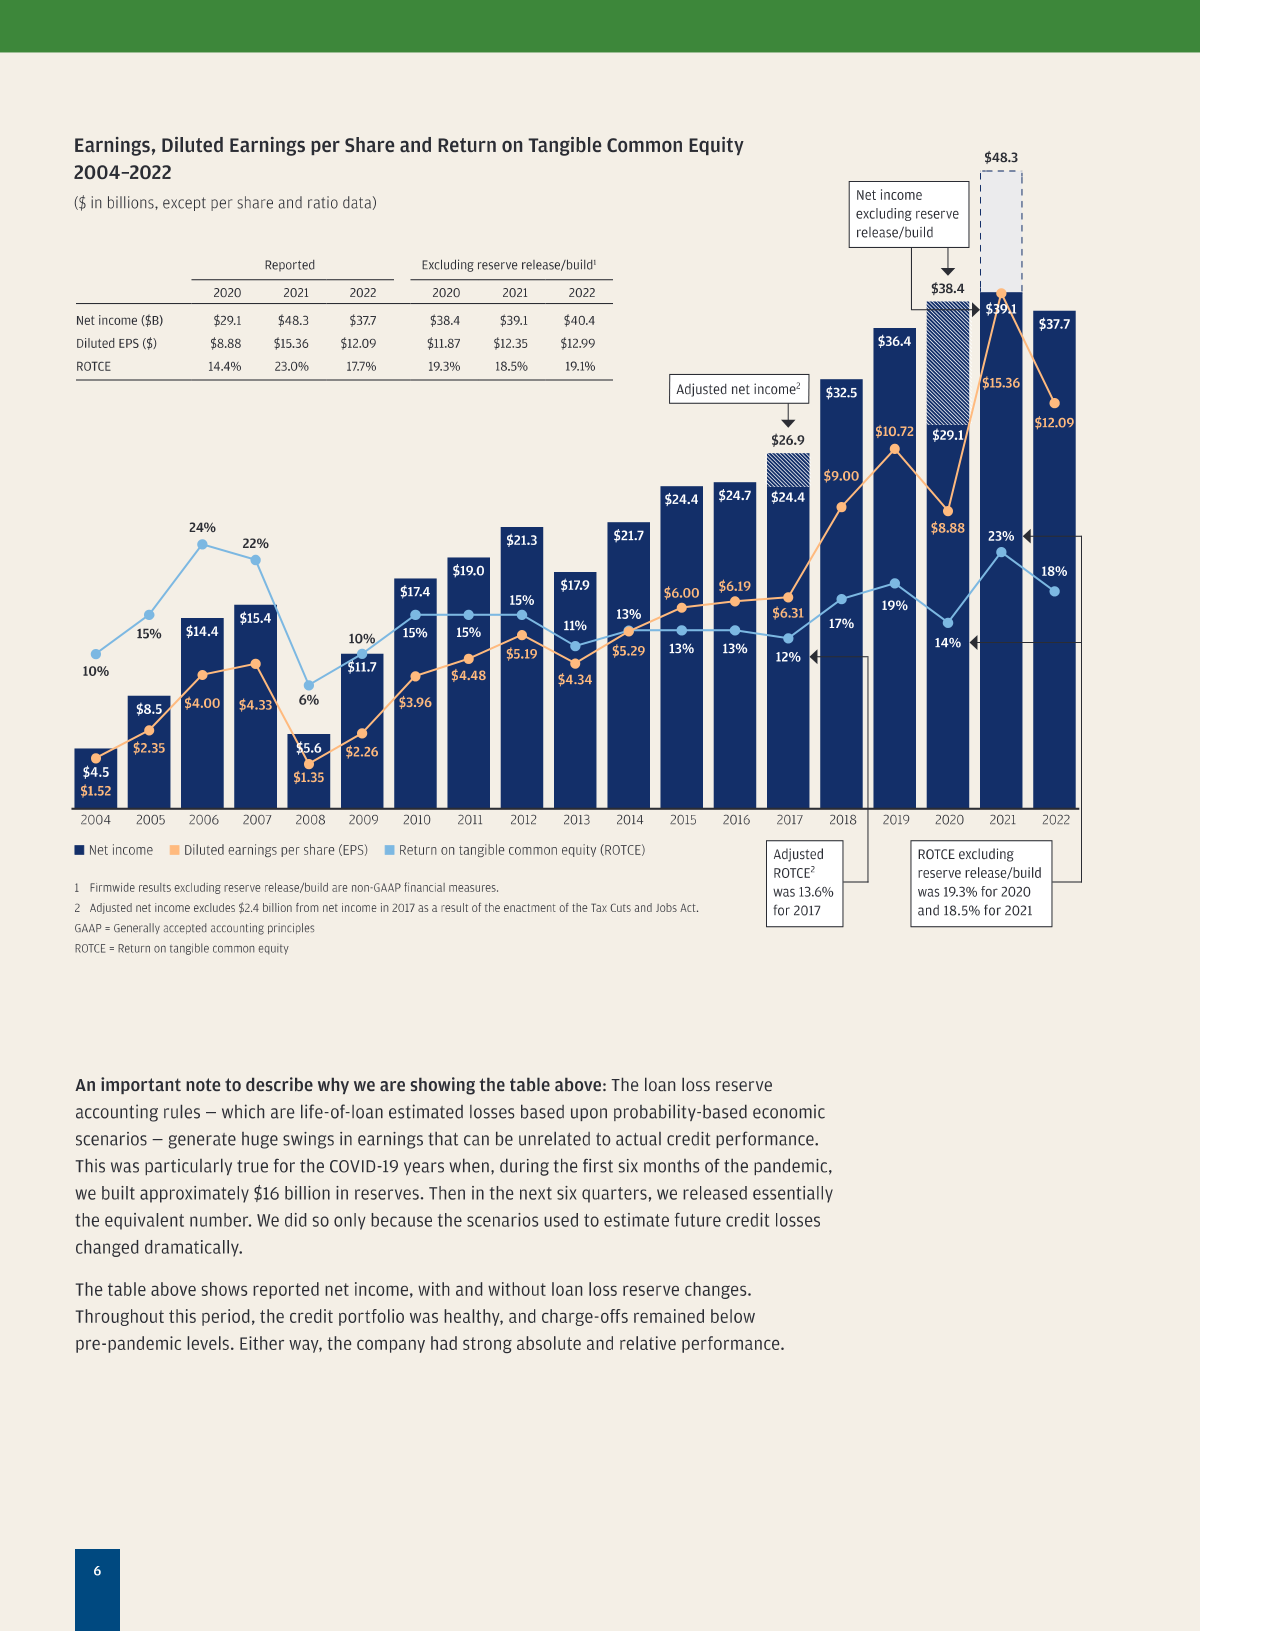

In [21]:
import fitz

# First we read the PDF file
# Then we convert the PDF to an image

pdf_path = "data/jpmc_annual_report_page_6.pdf"
doc = fitz.open(pdf_path)
img = convert_pdf_to_image(doc, page_number=0, dpi=150)
img

We will provide two prompts to the model:
- **Text Prompt**: Provide instructions for what data to extract from the image and the desired output format
- **Image Prompt**: Provide the image to the model as a base64 encoded string

In [22]:
text_prompt = """
Extract the data contained in the chart and provide it in a json format. The data should include the Net Income, Diluted EPS, and ROTCE from 2004 to 2022 and should be structured as follows:
{"net_income":{"units:"$B", "data_points":{"2004": 4.5}}, "diluted_eps":{...}, "rotce":{...}}

"""
image_prompt = convert_pil_image_to_b64(img)

In [23]:
body = json.dumps(
    {
        "max_tokens": 1024,
        "messages": prompts_to_messages(
            [
                {
                    "role": "user",
                    "text_prompt": text_prompt,
                    "image_prompt": image_prompt,
                },
                {"role": "assistant", "text_prompt": "```json"}, # we start the generated response with a json code block to format the response
            ]
        ),
        "anthropic_version": "bedrock-2023-05-31",
    }
)

modelId = "anthropic.claude-3-sonnet-20240229-v1:0" 
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read().decode("utf8"))

rprint(Markdown(f'```json\n{response_body.get("content")[0]["text"]}'))

                                                                                                                   
                                                                                                                   
 {                                                                                                                 
   "net_income": {                                                                                                 
     "units": "$B",                                                                                                
     "data_points": {                                                                                              
       "2004": 4.5,                                                                                                
       "2005": 8.5,                                                                                                
       "2006": 14.0,                                                                                               
       "2007": 15.4,                                                                                               
       "2008": 5.6,                                                                                                
       "2009": 11.7,                                                                                               
       "2010": 17.4,                                                                                               
       "2011": 19.0,                                                                                               
       "2012": 21.3,                                                                                               
       "2013": 17.9,                                                                                               
       "2014": 21.8,                                                                                               
       "2015": 24.4,                                                                                               
       "2016": 24.7,                                                                                               
       "2017": 24.4,                                                                                               
       "2018": 32.5,                                                                                               
       "2019": 36.4,                                                                                               
       "2020": 29.1,                                                                                               
       "2021": 48.3,                                                                                               
       "2022": 37.7                                                                                                
     }                                                                                                             
   },                                                                                                              
   "diluted_eps": {                                                                                                
     "units": "",                                                                                                  
     "data_points": {                                                                                              
       "2004": 2.92,                                                                                               
       "2005": 3.35,                                                                                               
       "2006": 4.33,                                                                                               
       "2007": 4.39,                                                                                               
       "2008": 1.37,                                    

Are the numbers above accurate? With such a simple prompt, likely not.

What can we do to make it better? 

See if you can adjust the prompt to get more accurate results.


## Conclusion

We are just getting warmed up, we explored basic prompting techiques with Claude model. Please proceed to the next Notebook.